In [1]:
#install packages and set display
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# Set pandas display options
pd.set_option('display.max_colwidth', None)

In [2]:
def scrape_player_stats(player_href):
    """
    Scrapes detailed player statistics from their profile page.
    Args:
        player_href (str): URL of the player's profile page.    
    Returns:
        DataFrame: A pandas DataFrame containing the player's statistics.
    """
    response = requests.get(player_href)  # Send a GET request to the player's profile page
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')  # Parse the HTML content
        player_name = soup.find('h1').text.strip()  # Extract player name from the page header
        table = soup.find('table', id='per_game')  # Find the table with per-game statistics
        if table:
            df = pd.read_html(str(table))[0]  # Read the table into a DataFrame
            #if isinstance(df.columns, pd.MultiIndex):  # Check if columns have multiple levels
            #    df.columns = df.columns.droplevel(0)  # Drop multi-index level if present
            df = df[df['Season'].notna()]  # Remove rows without season data
            df['Season'] = df['Season'].str.split('-').str[0]  # Keep only the starting year of the season
            df['player_name'] = player_name  # Add player name to the stats DataFrame
            df = df[df['Age'].notnull()]  # Include rows where 'Age' is not null - this elimates the season totals
            
            return df
    return pd.DataFrame()  # Return an empty DataFrame if the page couldn't be loaded or the table wasn't found

In [3]:
url = 'https://www.basketball-reference.com/players/d/doncilu01.html'
player = scrape_player_stats(url)

In [4]:
player

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,player_name
0,2018,19.0,DAL,NBA,SG,72,72,32.2,7.0,16.5,...,6.6,7.8,6.0,1.1,0.3,3.4,1.9,21.2,ROY-1,Luka Dončić
1,2019,20.0,DAL,NBA,PG,61,61,33.6,9.5,20.6,...,8.1,9.4,8.8,1.0,0.2,4.3,2.5,28.8,"MVP-4,NBA1,AS,MIP-3",Luka Dončić
2,2020,21.0,DAL,NBA,PG,66,66,34.3,9.8,20.5,...,7.2,8.0,8.6,1.0,0.5,4.3,2.3,27.7,"MVP-6,NBA1,AS",Luka Dončić
3,2021,22.0,DAL,NBA,PG,65,65,35.4,9.9,21.6,...,8.3,9.1,8.7,1.2,0.6,4.5,2.2,28.4,"MVP-5,NBA1,AS",Luka Dončić
4,2022,23.0,DAL,NBA,PG,66,66,36.2,10.9,22.0,...,7.8,8.6,8.0,1.4,0.5,3.6,2.5,32.4,"MVP-8,NBA1,AS,CPOY-8",Luka Dončić
5,2023,24.0,DAL,NBA,PG,70,70,37.5,11.5,23.6,...,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,"MVP-3,AS,CPOY-6",Luka Dončić


In [5]:
def scrape_nba_career_points_leaders(url1, n):
    """
    Scrapes the NBA career points leaders from the provided URL. Retrieves the top n players.
    Args:
        url1 (str): URL of the NBA career points leaders page.
        n (int): Number of top players to retrieve from the URL.    
    Returns:
        DataFrame: A pandas DataFrame containing the top n players.
    """
    response = requests.get(url1)  # Send a GET request to the URL
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')  # Parse the HTML content
        table_container = soup.find('div', id='div_tot')  # Find the container with the table
        if table_container:
            table = table_container.find('table', id='tot')  # Find the table within the container
            rows = table.find_all('tr')  # Extract all rows from the table
            data = []
            for row in rows[1:n+1]:  # Skip the header row and limit to top n players
                cols = row.find_all('td')  # Find all columns in the row
                if cols:
                    # Extract and clean data from each column
                    rank = cols[0].text.strip()
                    player_name = cols[1].text.strip() #get player name and remove spaces
                    points = cols[2].text.strip()
                    href = cols[1].find('a')['href'] if cols[1].find('a') else None
                    full_href = f"https://www.basketball-reference.com{href}" if href else None  # Construct full URL
                    data.append({'Rank': rank, 'Player': player_name, 'PTS': points, 'Href': full_href})
            return pd.DataFrame(data)  # Create a DataFrame from the extracted data
        else:
            print("Table container not found.")
    else:
        print("Failed to load the page. Status code:", response.status_code)
    return pd.DataFrame()  # Return an empty DataFrame if the page couldn't be loaded

In [6]:
url_greats = 'https://www.basketball-reference.com/leaders/pts_career.html'
greats = scrape_nba_career_points_leaders(url_greats,5)

In [7]:
greats

,Rank,Player,PTS,Href
0,1.,LeBron James,40474,https://www.basketball-reference.com/players/j/jamesle01.html
1,2.,Kareem Abdul-Jabbar*,38387,https://www.basketball-reference.com/players/a/abdulka01.html
2,3.,Karl Malone*,36928,https://www.basketball-reference.com/players/m/malonka01.html
3,4.,Kobe Bryant*,33643,https://www.basketball-reference.com/players/b/bryanko01.html
4,5.,Michael Jordan*,32292,https://www.basketball-reference.com/players/j/jordami01.html


In [8]:
def clean_data(df):
    """
    Cleans the scraped data by removing unwanted characters and converting data types.
    Args:
        df (DataFrame): The DataFrame to be cleaned.   
    Returns:
        DataFrame: The cleaned DataFrame.
    """
    cleaned_df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    cleaned_df['Player'] = cleaned_df['Player'].str.replace('*', '', regex=False)  # Remove asterisks from player names
    cleaned_df['Rank'] = cleaned_df['Rank'].str.replace('.', '', regex=False).astype(int)  # Remove periods from ranks and convert to int
    cleaned_df['PTS'] = cleaned_df['PTS'].str.replace(',', '', regex=False).astype(int)  # Remove commas and convert to int
    return cleaned_df

In [9]:
clean = clean_data(greats)
clean

,Rank,Player,PTS,Href
0,1,LeBron James,40474,https://www.basketball-reference.com/players/j/jamesle01.html
1,2,Kareem Abdul-Jabbar,38387,https://www.basketball-reference.com/players/a/abdulka01.html
2,3,Karl Malone,36928,https://www.basketball-reference.com/players/m/malonka01.html
3,4,Kobe Bryant,33643,https://www.basketball-reference.com/players/b/bryanko01.html
4,5,Michael Jordan,32292,https://www.basketball-reference.com/players/j/jordami01.html


   Rank               Player    PTS  \
0     1         LeBron James  40474   
1     2  Kareem Abdul-Jabbar  38387   
2     3          Karl Malone  36928   
3     4          Kobe Bryant  33643   
4     5       Michael Jordan  32292   

                                                            Href  
0  https://www.basketball-reference.com/players/j/jamesle01.html  
1  https://www.basketball-reference.com/players/a/abdulka01.html  
2  https://www.basketball-reference.com/players/m/malonka01.html  
3  https://www.basketball-reference.com/players/b/bryanko01.html  
4  https://www.basketball-reference.com/players/j/jordami01.html  


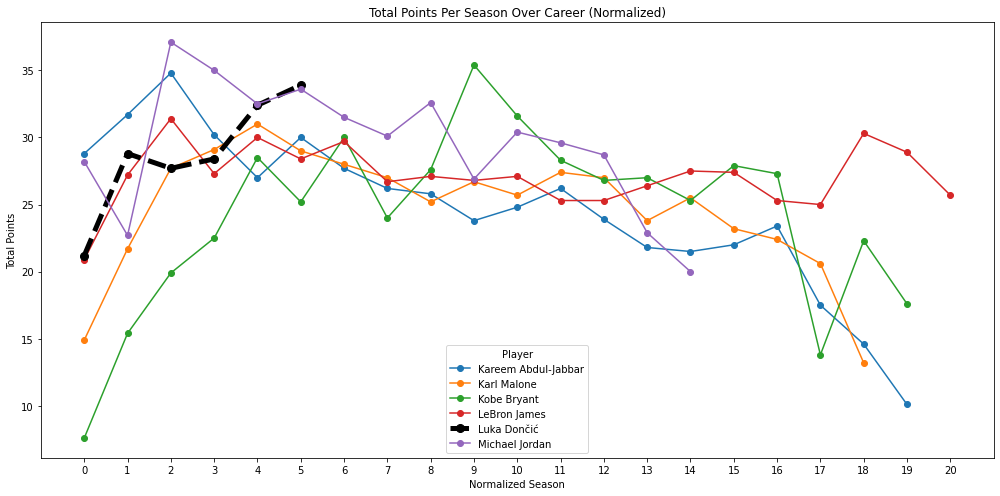

In [10]:
# Main script
url1 = 'https://www.basketball-reference.com/leaders/pts_career.html' # the greats
url2 = 'https://www.basketball-reference.com/players/d/doncilu01.html'  # Luka's profile page
#url2 = 'https://www.basketball-reference.com/players/n/nowitdi01.html' #Dirk's profile page
n = 5  # Number of top players to retrieve from the first URL

# Scrape the career points leaders from the first URL
df1 = scrape_nba_career_points_leaders(url1, n)

# Scrape player stats from the second URL
url2_stats = scrape_player_stats(url2)

# Extract the player name from the second URL data
url2_player_name = url2_stats['player_name'].iloc[0] if not url2_stats.empty else None

if not df1.empty and not url2_stats.empty:
    cleaned_df = clean_data(df1)  # Clean the scraped data
    print(cleaned_df.head(5))  # Display the top 5 rows of the cleaned data
    
    dataframes = []
    for index, row in cleaned_df.iterrows():
        player_stats = scrape_player_stats(row['Href'])  # Scrape player stats from profile page
        if not player_stats.empty:
            player_stats.rename(columns={'PTS': 'points', 'TRB': 'total_rebounds'}, inplace=True)  # Rename columns
            dataframes.append(player_stats)
    
    if not url2_stats.empty:
        url2_stats.rename(columns={'PTS': 'points', 'TRB': 'total_rebounds'}, inplace=True)
        dataframes.append(url2_stats)
    
    final_df = pd.concat(dataframes, ignore_index=True)  # Combine all player stats DataFrames into one
    final_df['points'] = pd.to_numeric(final_df['points'], errors='coerce')  # Convert points to numeric
    final_df.dropna(subset=['points'], inplace=True)  # Drop rows where points are NaN
    
    # Normalize 'Season' within each player group
    final_df['Normalized Season'] = final_df.groupby('player_name')['Season'].transform(lambda x: range(len(x)))
    
    # Plot setup
    plt.figure(figsize=(14, 7))
    
    # Group by player and plot
    for player, group in final_df.groupby('player_name'):
        group = group.sort_values('Normalized Season')  # Sort data by normalized season
        if player == url2_player_name:
            plt.plot(group['Normalized Season'], group['points'], label=player, color='black', linestyle='--', linewidth=5, marker='o', markersize=8)
        else:
            plt.plot(group['Normalized Season'], group['points'], label=player, marker='o')
    
    # Adding plot title and labels
    plt.title('Total Points Per Season Over Career (Normalized)')
    plt.xlabel('Normalized Season')
    plt.ylabel('Total Points')
    
    # Setting x-axis ticks to increment by 1
    max_season = final_df['Normalized Season'].max()
    plt.xticks(range(0, max_season + 1))
    
    # Add a legend to the plot
    plt.legend(title='Player')
    
    # Improve layout to accommodate the x-axis labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()
else:
    print("No data to display.")


In [11]:
url2_stats

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,DRB,total_rebounds,AST,STL,BLK,TOV,PF,points,Awards,player_name
0,2018,19.0,DAL,NBA,SG,72,72,32.2,7.0,16.5,...,6.6,7.8,6.0,1.1,0.3,3.4,1.9,21.2,ROY-1,Luka Dončić
1,2019,20.0,DAL,NBA,PG,61,61,33.6,9.5,20.6,...,8.1,9.4,8.8,1.0,0.2,4.3,2.5,28.8,"MVP-4,NBA1,AS,MIP-3",Luka Dončić
2,2020,21.0,DAL,NBA,PG,66,66,34.3,9.8,20.5,...,7.2,8.0,8.6,1.0,0.5,4.3,2.3,27.7,"MVP-6,NBA1,AS",Luka Dončić
3,2021,22.0,DAL,NBA,PG,65,65,35.4,9.9,21.6,...,8.3,9.1,8.7,1.2,0.6,4.5,2.2,28.4,"MVP-5,NBA1,AS",Luka Dončić
4,2022,23.0,DAL,NBA,PG,66,66,36.2,10.9,22.0,...,7.8,8.6,8.0,1.4,0.5,3.6,2.5,32.4,"MVP-8,NBA1,AS,CPOY-8",Luka Dončić
5,2023,24.0,DAL,NBA,PG,70,70,37.5,11.5,23.6,...,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,"MVP-3,AS,CPOY-6",Luka Dončić


In [12]:
df1.head()

,Rank,Player,PTS,Href
0,1.,LeBron James,40474,https://www.basketball-reference.com/players/j/jamesle01.html
1,2.,Kareem Abdul-Jabbar*,38387,https://www.basketball-reference.com/players/a/abdulka01.html
2,3.,Karl Malone*,36928,https://www.basketball-reference.com/players/m/malonka01.html
3,4.,Kobe Bryant*,33643,https://www.basketball-reference.com/players/b/bryanko01.html
4,5.,Michael Jordan*,32292,https://www.basketball-reference.com/players/j/jordami01.html
